In [1]:
# !kaggle datasets download -d lyly99/logodet3k

In [2]:
# !unzip -qq -y '/kaggle/working/logodet3k.zip'

In [2]:
!pip install -q -U ultralytics
!pip install -U -q ipywidgets

In [3]:
# %load_ext tensorboard
# %tensorboard --logdir /kaggle/working/runs_track

In [4]:
from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.23 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 5597.6/8062.4 GB disk)


In [5]:
import os
import random
import glob
import shutil

import json
import yaml

from collections import defaultdict
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

from lxml import etree as ET

import pandas as pd
import matplotlib.pyplot as plt

import cv2
# from PIL import Image
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator
from IPython.display import display, Image

from sklearn.model_selection import train_test_split

In [6]:
dataset_dir = "/kaggle/input/logodet3k/LogoDet-3K"
# dataset_dir = "/home/sinewave/logocode_detection/datasets/LogoDet-3K"
os.listdir(dataset_dir)

['Leisure',
 'Sports',
 'Necessities',
 'Medical',
 'Electronic',
 'Clothes',
 'Transportation',
 'Food',
 'Others']

In [8]:
df = pd.DataFrame(glob.glob(f"{dataset_dir}/*/*/*"), columns=["file_path"])
df["ext"] = df["file_path"].apply(lambda x: x.split(".")[-1])
df["logo_category"] = df["file_path"].apply(lambda x: x.split(os.sep)[-3])
df["logo_name"] = df["file_path"].apply(lambda x: x.split(os.sep)[-2])
df.head()

,file_path,ext,logo_category,logo_name
0,/kaggle/input/logodet3k/LogoDet-3K/Leisure/Art...,jpg,Leisure,Artillery
1,/kaggle/input/logodet3k/LogoDet-3K/Leisure/Art...,jpg,Leisure,Artillery
2,/kaggle/input/logodet3k/LogoDet-3K/Leisure/Art...,jpg,Leisure,Artillery
3,/kaggle/input/logodet3k/LogoDet-3K/Leisure/Art...,jpg,Leisure,Artillery
4,/kaggle/input/logodet3k/LogoDet-3K/Leisure/Art...,jpg,Leisure,Artillery


In [9]:
# !du /kaggle/input/logodet3k/LogoDet-3K --human-readable -d 1
# !du /home/sinewave/logocode_detection/datasets/LogoDet-3K --human-readable -d 1

In [10]:
df.to_csv("logodet3k_reference.csv", index=False)

In [11]:
df["ext"].value_counts()

ext
jpg    158654
xml    158654
Name: count, dtype: int64

In [7]:
df = pd.read_csv('/kaggle/working/logodet3k_reference.csv')

In [8]:
df2 = df[df["ext"]=="jpg"].iloc[:]
print({
    "No. of categories": df2["logo_category"].nunique(), 
    "No. of logo types": df2["logo_name"].nunique(),
    "Avg. no. of images per category": df2.groupby("logo_category")["file_path"].count().mean().round(), 
    "Avg. no. of images per logo": df2.groupby("logo_name")["file_path"].count().mean().round(), 
})

{'No. of categories': 9, 'No. of logo types': 3000, 'Avg. no. of images per category': 17628.0, 'Avg. no. of images per logo': 53.0}


In [12]:
df2["logo_category"].value_counts()

logo_category
Food              53350
Clothes           31266
Necessities       24822
Others            15513
Transportation    10445
Electronic         9675
Leisure            5685
Sports             3953
Medical            3945
Name: count, dtype: int64

<Axes: title={'center': 'Distribution of logo img counts'}, xlabel='logo_name'>

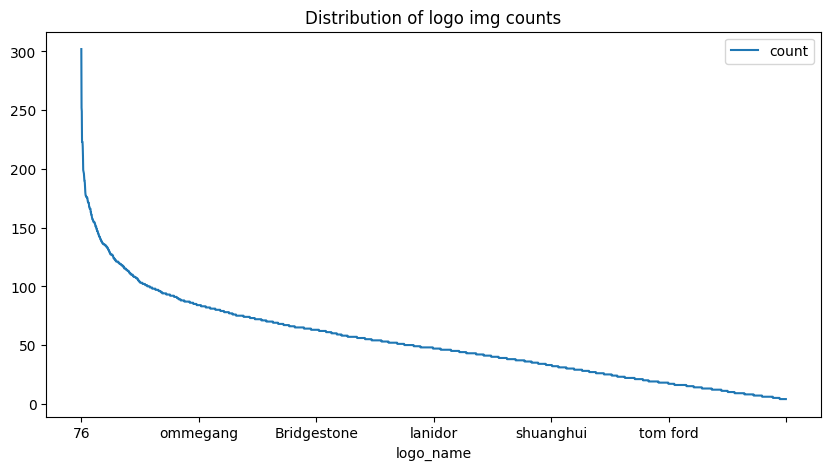

In [13]:
df2["logo_name"].value_counts().reset_index().plot(
    x="logo_name", y="count", figsize=(10,5), title="Distribution of logo img counts")

In [19]:
dataset_dst_dir = "/kaggle/working/logodet3k"
if os.path.exists(dataset_dst_dir):
    shutil.rmtree(dataset_dst_dir)
os.makedirs(f"{dataset_dst_dir}/train", exist_ok=True)
os.makedirs(f"{dataset_dst_dir}/val", exist_ok=True)

classname2idx = {logo_name: idx for idx, logo_name in enumerate(sorted(df2["logo_name"].unique()))}
print(str(classname2idx)[:100]+"...")
idx2classname = {idx: logo_name for logo_name, idx in classname2idx.items()}

classname2idx = {"logo": 0}
idx2classname = defaultdict(lambda: "logo")

class_name_idx_map_str = "\n".join([f"    {idx}: {class_name}" for class_name, idx in classname2idx.items()])
print(class_name_idx_map_str)

dataset_config = f"""
path: {dataset_dst_dir} 
train:
    - train
val:
    - val

# test:
#     - test

# Classes
names:
{class_name_idx_map_str}
"""
print(dataset_config)
with open("dataset_config.yaml", "w") as f:
    f.write(dataset_config)
print("-"*10)
with open("dataset_config.yaml", "r") as f:
    datcon = yaml.safe_load(f)
    print(datcon)

{'10 Cane': 0, '1519 Tequila': 1, '241 Pizza': 2, '2XU': 3, '2xist': 4, '3D-GOLD': 5, '3nod': 6, '3t...
    0: logo

path: /kaggle/working/logodet3k 
train:
    - train
val:
    - val

# test:
#     - test

# Classes
names:
    0: logo

----------
{'path': '/kaggle/working/logodet3k', 'train': ['train'], 'val': ['val'], 'names': {0: 'logo'}}


In [9]:
def convert_voc_to_yolo(src, dst, classname2idx):
    tree = ET.parse(src)
    root = tree.getroot()
    yolo_lines = []
    image_width = float(root.find("size/width").text)
    image_height = float(root.find("size/height").text)
    depth = float(root.find("size/depth").text)
    for obj in root.findall('object'):
        class_name = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = float(bbox.find('xmin').text)
        ymin = float(bbox.find('ymin').text)
        xmax = float(bbox.find('xmax').text)
        ymax = float(bbox.find('ymax').text)
        x_center = (xmin + xmax) / 2 / image_width
        y_center = (ymin + ymax) / 2 / image_height
        width = (xmax - xmin) / image_width
        height = (ymax - ymin) / image_height
        class_index = classname2idx.get(class_name, 0)
#         yolo_line = f"{class_index} {round(x_center, 6)} {round(y_center, 6)} {round(width, 6)} {round(height, 6)}"
        yolo_line = f"{class_index} {x_center} {y_center} {width} {height}"
        yolo_lines.append(yolo_line)
    if dst is not None:
        with open(dst, "w") as f:
            f.write("\n".join(yolo_lines))
    return yolo_lines
    
convert_voc_to_yolo(f"{dataset_dir}/Clothes/2xist/1.xml", None, {})

In [21]:
df2['is_train'] = True
train_df, test_df = train_test_split(df2, test_size=0.2, random_state=101)
test_df['is_train'] = False
final_df = pd.concat([train_df, test_df])
final_df.reset_index(drop=True, inplace=True)

def copy_to_working(x):
    train_folder = "train" if x["is_train"] else "val"
    src = x["file_path"]
    dst = os.path.join(dataset_dst_dir, train_folder, "__".join(x["file_path"].split(os.sep)[-3:]))
    if not os.path.exists(dst):
        shutil.copy(src, dst)
    if not os.path.exists(dst.replace(".jpg", ".txt")):
        convert_voc_to_yolo(src.replace(".jpg", ".xml"), dst.replace(".jpg", ".txt"), classname2idx)
    return True

# copy_to_working(final_df.iloc[0].T.to_dict())
copy_to_working_results = []

with ThreadPoolExecutor() as e:
    for _, row in tqdm(final_df.iterrows()):
        status = e.submit(copy_to_working, dict(row))
        copy_to_working_results.append(status)
        
copy_to_working_results = final_df.apply(lambda x: copy_to_working(x), axis=1)
copy_to_working_results.sum(), final_df.shape[0]

158654it [00:20, 7706.85it/s]


(158654, 158654)

In [22]:
copy_to_working_results.sum(), final_df.shape[0]

(158654, 158654)

In [19]:
model = YOLO('yolov8m.pt')
# model = YOLO('yolov8x.pt')

In [10]:
def plot_bboxes(r):
    annotator = Annotator(r.orig_img)
    boxes = r.boxes
    for box in boxes:
        b = box.xyxy[0]
        c = box.cls
        annotator.box_label(b, model.names[int(c)])
    img = annotator.result() 
    return img

In [21]:
!wget -O person.jpg https://www.indiafilings.com/learn/wp-content/uploads/2023/03/Can-a-single-person-own-a-firm-in-India.jpg

--2024-05-27 09:59:21--  https://www.indiafilings.com/learn/wp-content/uploads/2023/03/Can-a-single-person-own-a-firm-in-India.jpg
Resolving www.indiafilings.com (www.indiafilings.com)... 104.17.66.1, 104.17.65.1, 2606:4700::6811:4101, ...
Connecting to www.indiafilings.com (www.indiafilings.com)|104.17.66.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33364 (33K) [image/jpeg]
Saving to: 'person.jpg'

person.jpg          100%[===================>]  32.58K  --.-KB/s    in 0.01s   

2024-05-27 09:59:21 (3.10 MB/s) - 'person.jpg' saved [33364/33364]




image 1/1 /kaggle/working/person.jpg: 448x640 1 person, 1 laptop, 68.5ms
Speed: 12.6ms preprocess, 68.5ms inference, 2313.5ms postprocess per image at shape (1, 3, 448, 640)


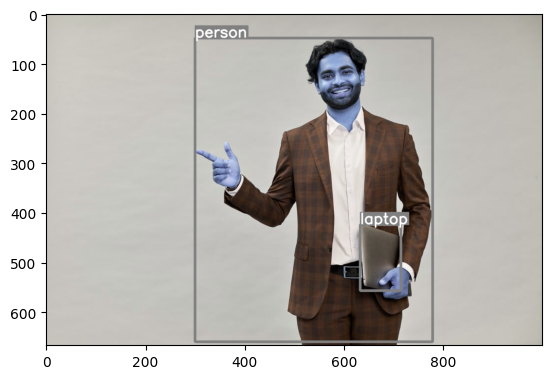

In [22]:
plt.imshow(plot_bboxes(model("person.jpg")[0]))
plt.show()

In [11]:
logos_sample = list(df2.sample(10).T.to_dict().values())
results = model([logo["file_path"]for logo in logos_sample])
print(len(results))
for r in results:
    img = plot_bboxes(r)
    plt.imshow(img)
    plt.show()

NameError: name 'model' is not defined

In [24]:
# !yolo train model=yolov8n.pt data=dataset_config.yaml epochs=3 imgsz=640
# !yolo export model=yolov8n_simple_train.pt
# !yolo val model=yolov8n_simple_train.pt data=dataset_config.yaml

In [25]:
# img_path = random.choice(logos_sample)["file_path"]
# print("\n".join(convert_voc_to_yolo(img_path.replace(".jpg", ".xml"), None, {})))
# Image(img_path)

In [ ]:
test_results = model.train(data='dataset_config.yaml', epochs=2)
#, cache=True) # dont turn cache true it will run out of memory
print(test_results)

Ultralytics YOLOv8.2.22 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/runs/detect/train2/weights/best.pt, data=dataset_config.yaml, epochs=2, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, 

train: Scanning /kaggle/working/logodet3k/train... 126923 images, 0 backgrounds, 0 corrupt: 100%|██████████| 126923/126923 [01:41<00:00, 1248.24it/s]

train: WARNING ⚠️ /kaggle/working/logodet3k/train/Food__violet crumble__5.jpg: 1 duplicate labels removed


train: New cache created: /kaggle/working/logodet3k/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/logodet3k/val... 31731 images, 0 backgrounds, 0 corrupt: 100%|██████████| 31731/31731 [00:25<00:00, 1267.52it/s]


val: New cache created: /kaggle/working/logodet3k/val.cache
Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train3
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2      8.84G      1.261      1.337      1.454         25        640: 100%|██████████| 7933/7933 [1:22:58<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 992/992 [06:00<00:00,  2.75it/s]


                   all      31731      38893      0.615      0.646      0.651      0.386

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2      8.98G      1.237      1.306      1.437         41        640:  62%|██████▏   | 4946/7933 [50:57<30:22,  1.64it/s]  

WARNING ⚠️ 'format' argument is missing. Using default 'format=torchscript'.
Ultralytics YOLOv8.2.22 🚀 Python-3.10.13 torch-2.1.2 CPU (Intel Xeon 2.00GHz)
Model summary (fused): 218 layers, 25840339 parameters, 0 gradients, 78.7 GFLOPs

PyTorch: starting from '/kaggle/working/runs/detect/train2/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (49.6 MB)

TorchScript: starting export with torch 2.1.2...
TorchScript: export success ✅ 4.6s, saved as '/kaggle/working/runs/detect/train2/weights/best.torchscript' (99.0 MB)

Export complete (8.0s)
Results saved to /kaggle/working/runs/detect/train2/weights
Predict:         yolo predict task=detect model=/kaggle/working/runs/detect/train2/weights/best.torchscript imgsz=640  
Validate:        yolo val task=detect model=/kaggle/working/runs/detect/train2/weights/best.torchscript imgsz=640 data=dataset_config.yaml  
Visualize:       https://netron.app
💡 Learn more at https://docs.ultralytics.com/modes/export

In [13]:
model = YOLO('/kaggle/working/runs/detect/train3/weights/best.pt')

In [14]:
val_results = model.val()
print(val_results)

Ultralytics YOLOv8.2.23 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
Model summary (fused): 218 layers, 25840339 parameters, 0 gradients, 78.7 GFLOPs


100%|██████████| 755k/755k [00:00<00:00, 41.4MB/s]
val: Scanning /kaggle/working/logodet3k/val.cache... 31731 images, 0 backgrounds, 0 corrupt: 100%|██████████| 31731/31731 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1984/1984 [06:14<00:00,  5.30it/s]


                   all      31731      38893      0.659      0.693      0.712      0.444
Speed: 0.1ms preprocess, 8.2ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/val3
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e996099fd00>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.03303

In [ ]:
exported_model = model.export()

In [ ]:
print(exported_model)

In [ ]:
import os
for folder_name, _, files in os.walk("/kaggle/working/runs"):
    print(folder_name, files)

In [ ]:
# !tar czf /kaggle/working/runs.tar.gz /kaggle/working/runs

In [ ]:
# !ls 

In [ ]:
# model = YOLO(exported_model.replace(".torchscript",".pt"))
# model = YOLO("/kaggle/input/yolo-single-logo/pytorch/v1/1/best_yolov8x_one_class.pt")


0: 640x640 2 logos, 11.8ms
1: 640x640 1 logo, 11.8ms
2: 640x640 1 logo, 11.8ms
3: 640x640 2 logos, 11.8ms
4: 640x640 1 logo, 11.8ms
5: 640x640 1 logo, 11.8ms
6: 640x640 2 logos, 11.8ms
7: 640x640 1 logo, 11.8ms
8: 640x640 2 logos, 11.8ms
9: 640x640 2 logos, 11.8ms
Speed: 2.9ms preprocess, 11.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
10


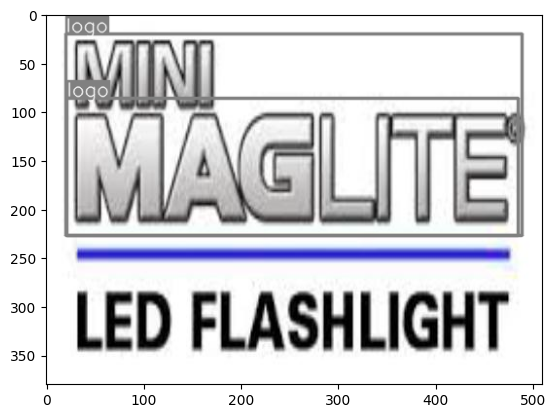

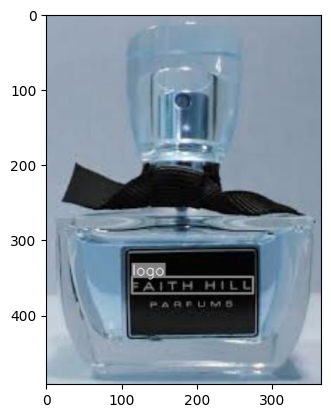

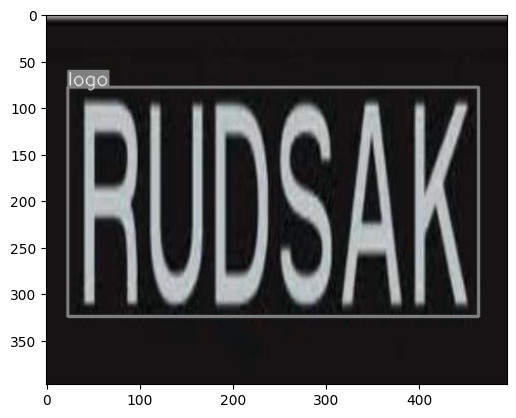

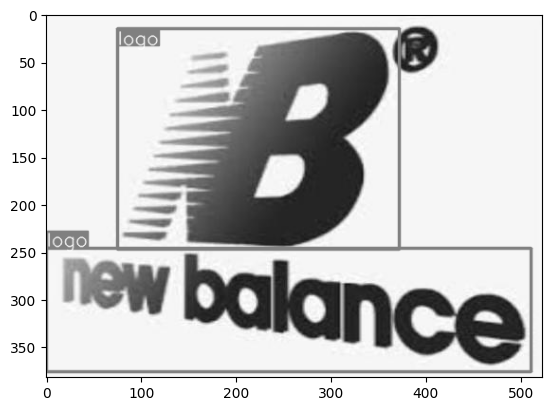

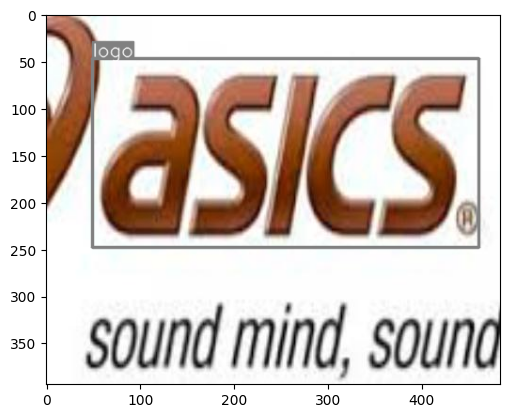

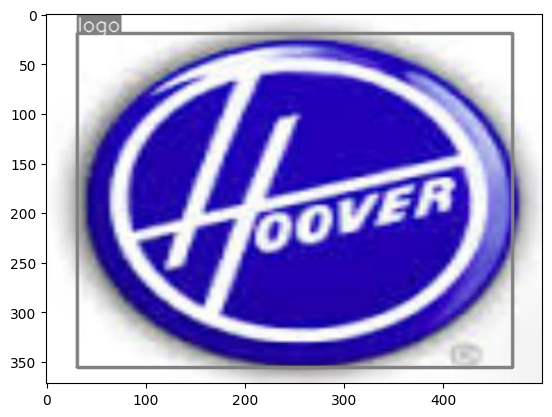

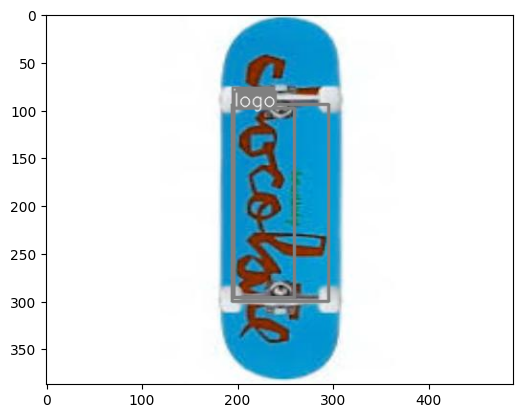

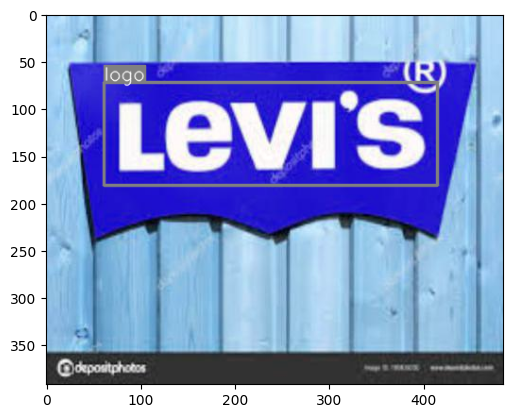

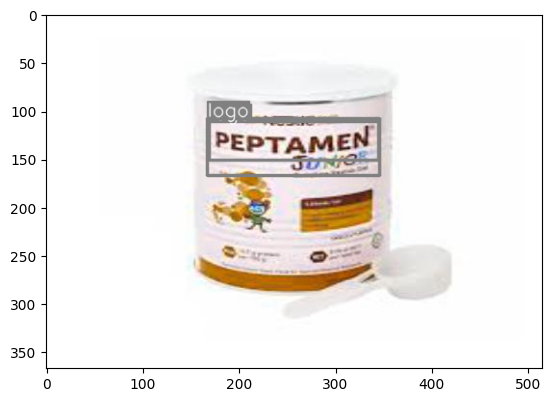

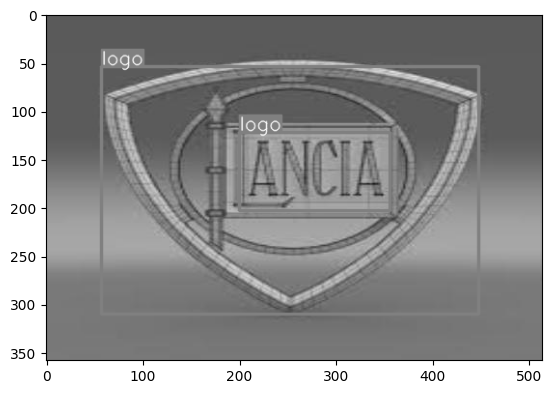

In [15]:
results = model([logo["file_path"]for logo in logos_sample])
print(len(results))
for r in results:
    img = plot_bboxes(r)
    plt.imshow(img)
    plt.show()


0: 640x640 (no detections), 37.0ms
1: 640x640 1 logo, 37.0ms
Speed: 2.4ms preprocess, 37.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
2


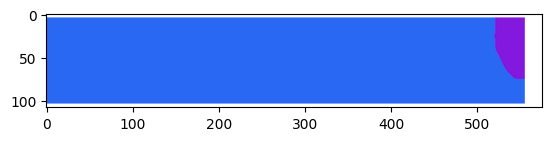

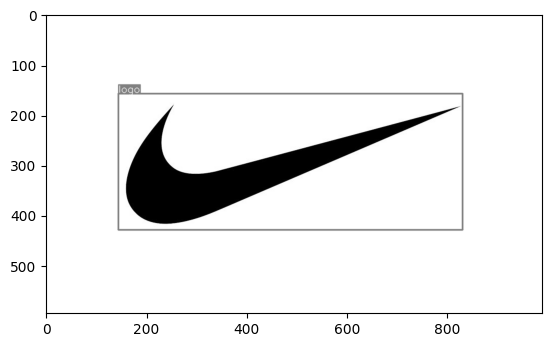

In [16]:
results = model(["https://s3-ap-southeast-1.amazonaws.com/assets.limetray.com/assets/user_images/logos/original/1602742091_DUNKINLogo.png",
                 "https://media.designrush.com/inspiration_images/134805/conversions/_1512076803_93_Nike-desktop.jpg"])
print(len(results))
for r in results:
    img = plot_bboxes(r)
    plt.imshow(img)
    plt.show()

In [ ]:
model